In [4]:
#Questions

#Q1
#Do we include correlations between target variables? or just between features and target variables?

#Q2
#Do we do this for all numerical features? That's a ton of histograms

#Q3

#Q7/8
#Is it okay if we remove the country-year column? It's redundant information which would bias our classifier
#Remove instant and dteday from bike dataset? Doesn't carry important info. If not, how to standardize date?
#Remove ID from vid dataset?
#Do we do this for the target variables? Assuming no

#Q9
#What to do about Nan features? Set to 0? Set to column mean? Remove example entirely?
#How many features should we take?
#Can we use just one of the two given feature selection methods?


In [5]:
#Q1a


#Targets: suicide_no and suicide/100k

#number of suicides highly correlated with population. For a fixed suicide rate, a higher population will result in a higher number of suicides
#suicide rate slightly correlated with number of suicides. suicide_rate = suicide_no/pop. Strength of the correlation depends on pop


#Q2a

import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

suic_df = pd.read_csv("archive/master.csv")
suic_profile = ProfileReport(suic_df, title="Suicide Profiling Report")
suic_profile.to_widgets()

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
#Q1b

#Targets: casual, registered, cnt

#High correlation between registered and cnt. This implies that most users are registered 
#Medium negative correlation between "workingday" and casual. Workingday is 1 if the day is a holiday/weekend, 0 o.w.
    #Implies that casual users tend to do most of their biking during the weekened/holidays - makes sense
    #since they're probably doing it as a chill activity, rather than a daily workout or a means to get to work/school

#All three have medium-high correlations with temp/atemp. People like biking in warmer weather
#Registered/cnt have medium-high correlations with year - most registered bikers were biking in 2012.
    # could imply that people have been using rental bikes more in more, so there were just more users in 2012 than 2011.

bike_df = pd.read_csv("Bike-Sharing-Dataset/day.csv")
bike_profile = ProfileReport(bike_df, title="Bike Sharing Profiling Report")
bike_profile.to_widgets()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
#Q1c

#Target variables: utime (transcoding time)

#Transcoding time high correlated with total codec allocated memory for transcoding, and medium-high correlation
#transcoding width/height. It takes longer to transcode larger sequences, which also means that it takes more memory to
#transcode the sequence



vid_df = pd.read_csv("online_video_dataset/transcoding_mesurment.tsv", delimiter='\t')
vid_profile = ProfileReport(vid_df, title="Video Transcoding Profiling Report")
vid_profile.to_widgets()

Summarize dataset:   0%|          | 0/35 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

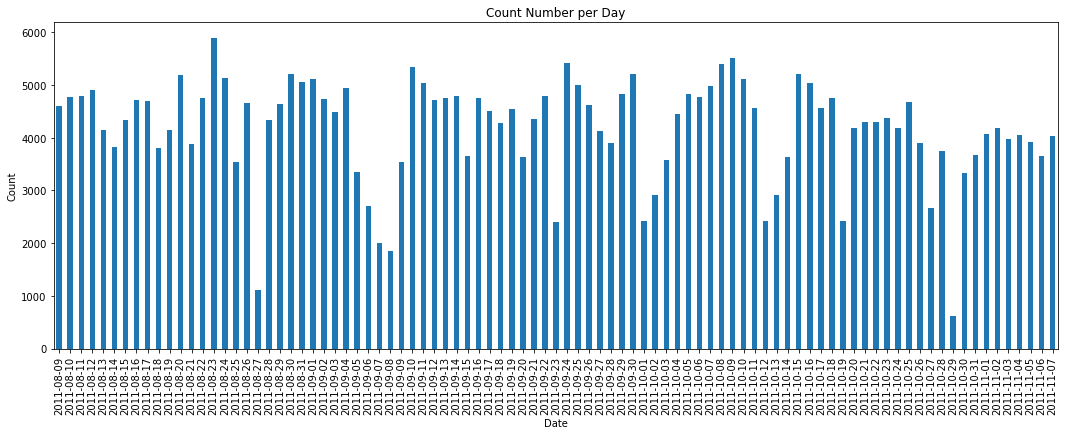

In [8]:
#Q4 
import matplotlib.pyplot as plt
trunc_bike_df = bike_df.truncate(before=220,after=310)
trunc_bike_df.plot(kind='bar',x='dteday',y='cnt', 
                   title='Count Number per Day',xlabel ='Date',
                  ylabel = 'Count',figsize = (18,6), legend = False)

plt.show()

#I picked some random indexes into the graph - not sure is this is the best one
#Looks like ridership goes way down on weekends, esp. Saturdays

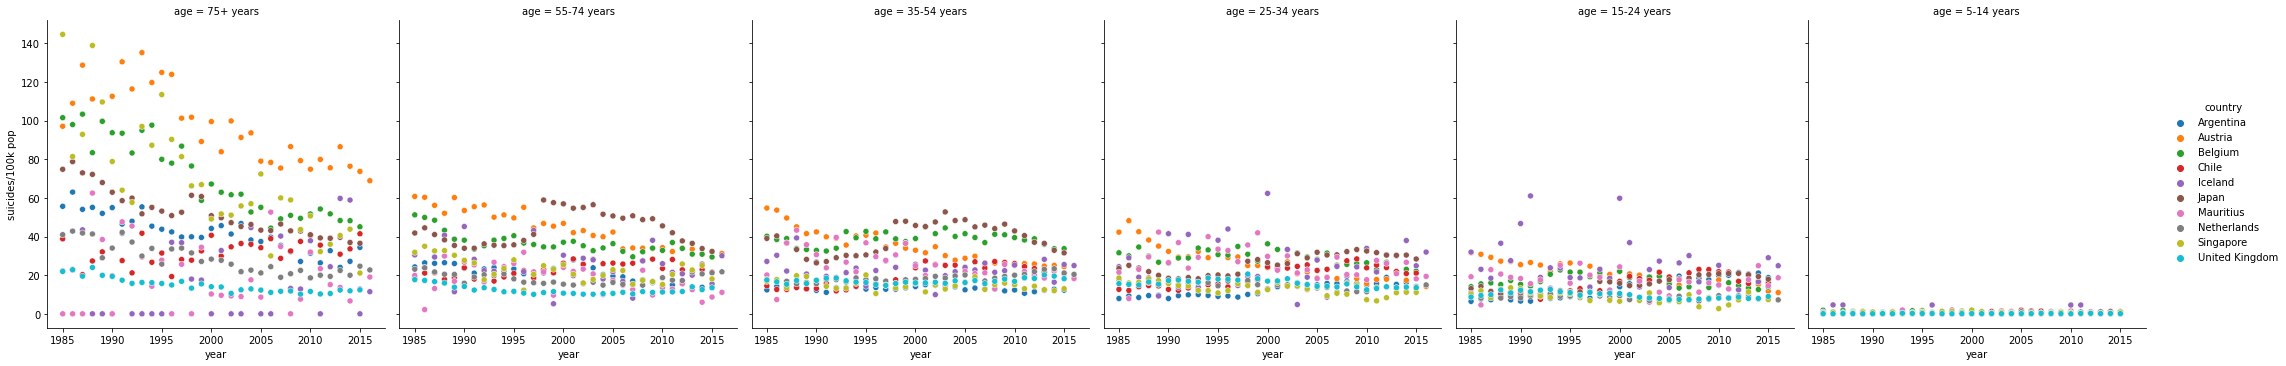

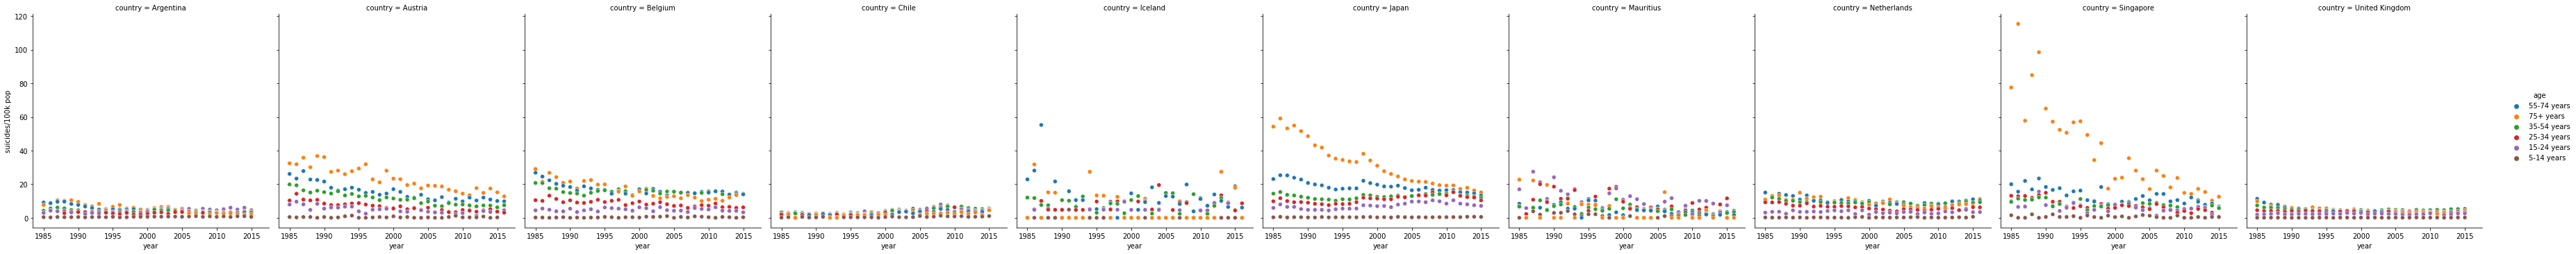

In [9]:
#Q5
import seaborn

top_countries = suic_df["country"].value_counts()[:10].index.tolist()
filtered_suic_df = suic_df[suic_df.country.isin(top_countries)]
male_df = filtered_suic_df[filtered_suic_df["sex"]=="male"]
female_df = filtered_suic_df[filtered_suic_df["sex"]=="female"]

#currently using two different ways of showing the data for male and female subsets
#should defintely pick just one (or a more granular one)

seaborn.relplot(data=male_df, x="year", y="suicides/100k pop", hue="country",col="age")
seaborn.relplot(data=female_df, x="year", y="suicides/100k pop", hue="age",col="country")

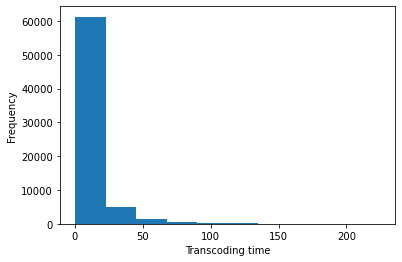

Mean: 9.996354820888579 s
Median: 4.408 s


In [10]:
#Q6
import matplotlib.pyplot as plt


#Most transcodings take very little time: between 0s and 10s

utime_vals = vid_df['utime'].to_numpy()
plt.hist(utime_vals)
plt.xlabel("Transcoding time")
plt.ylabel("Frequency")
plt.show()

print("Mean: {} s".format(np.mean(utime_vals)))
print("Median: {} s".format(np.median(utime_vals)))

In [21]:
#Q7, Q8

#What information does one-hot encoding discard?
#With numerical encoding: e.g. {1, 2, ... 12} for {Jan, Feb, ... Dec} we preserve distance information in the euclidean
#space between the months. We know that Jan and Mar surround Feb (not necessarily in that order).For encoding with one-hot encoding we 
#lose this information, and all months appear to be equidistant to each other. For some applications this doesn't matter,
#but it's definitely something that needs to be considered. For the quality feature vector {Poor, Fair, Typical, Good, Excellent} 
#if we proceed with one-hot encoding we also lose that distance information, so Excellent would be equidistant to
#Good and Poor, and we lose our sense of scale.

#What assumption should hold strongly if we perform the scalar encoding instead?


#Convert countries to continents:
#https://stackoverflow.com/questions/55910004/get-continent-name-from-country-using-pycountry

from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler


##### Suicide Dataset #####
def country_to_continent(country_name):
    try:
        item = country_alpha2_to_continent_code(country_name_to_country_alpha2(country_name))
        
    #Handle countries not in pycountry
    except KeyError:
        if (country_name == "Republic of Korea"):
            item = 'AS'
        elif (country_name == "Saint Vincent and Grenadines"):
            item = 'SA'
        else:
            print(country_name)
    return item


suic_df_preprocessed = suic_df.copy()

#Convert countries to a continent code
suic_df_preprocessed["country"] = suic_df_preprocessed["country"].apply(lambda x: country_to_continent(x))

#Remove country-year feature. Also remove target variables
suic_df_preprocessed = suic_df_preprocessed.drop(['country-year', 'suicides/100k pop', 'suicides_no'], axis=1)

#Necessary because values with commas can't be converted to floats
suic_df_preprocessed[' gdp_for_year ($) ']=suic_df_preprocessed[' gdp_for_year ($) '].str.replace(',','')

preprocess_suic = make_column_transformer(
    (StandardScaler(),['year', 'population', 'HDI for year', ' gdp_for_year ($) ', 'gdp_per_capita ($)']),
    (OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), ['country', 'sex', 'age', 'generation']),
    remainder='passthrough'
)

suic_df_preprocessed = preprocess_suic.fit_transform(suic_df_preprocessed)
#print(suic_df_preprocessed)



##### Bike Dataset #####
bike_df_preprocessed = bike_df.copy()

#Remove seeemingly useless columns and target variables
bike_df_preprocessed = bike_df_preprocessed.drop(['instant', 'dteday', 'cnt', 'casual', 'registered'], axis=1)

preprocess_bike = make_column_transformer(
    (StandardScaler(), bike_df_preprocessed.columns),
    remainder='passthrough'
)

bike_df_preprocessed = preprocess_bike.fit_transform(bike_df_preprocessed)
#print(bike_df_preprocessed)



##### Video Dataset #####

vid_df_preprocessed = vid_df.copy()

#Remove ID column. Carries no important information
vid_df_preprocessed = vid_df_preprocessed.drop(['id', 'utime'], axis=1)

#Preprocess all but utime
preprocess_vid = make_column_transformer(
    (StandardScaler(), vid_df_preprocessed.columns.drop(['codec', 'o_codec'])),
    (OneHotEncoder(sparse=False, categories='auto', handle_unknown='ignore'), ['codec', 'o_codec']),
    remainder='passthrough'
)

vid_df_preprocessed = preprocess_vid.fit_transform(vid_df_preprocessed)
#print(vid_df_preprocessed)

In [29]:
#Q9

from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest


#Currently using ~3/4 of all features from mutual_info_regression - I have no idea how many we should be using

fraction_of_total = 0.75
num_feat_suic = int(np.floor(fraction_of_total * suic_df_preprocessed.shape[1]))
score_func_suic = mutual_info_regression
#score_func_suic = f_regression

num_feat_bike = int(np.floor(fraction_of_total * bike_df_preprocessed.shape[1]))
score_func_bike = mutual_info_regression
#score_func_bike = f_regression

num_feat_vid = int(np.floor(fraction_of_total * vid_df_preprocessed.shape[1]))
score_func_vid = mutual_info_regression
#score_func_vid = f_regression


fs_suic = SelectKBest(score_func=score_func_suic, k=num_feat_suic)
fs_bike = SelectKBest(score_func=score_func_bike, k=num_feat_bike)
fs_vid = SelectKBest(score_func=score_func_vid, k=num_feat_vid)

labels_suic = suic_df['suicides/100k pop']
labels_bike = bike_df['cnt']
labels_vid = vid_df['utime']

#Set nan to 0. Can change later
df_nans = np.isnan(suic_df_preprocessed)
suic_df_preprocessed[df_nans] = 0

#Pick top k features
suic_data_ready = fs_suic.fit_transform(suic_df_preprocessed, labels_suic)
bike_data_ready = fs_bike.fit_transform(bike_df_preprocessed, labels_bike)
vid_data_ready = fs_vid.fit_transform(vid_df_preprocessed, labels_vid)


In [39]:
#Neural Networks

#Q17
#The FC network is capable of learning non-linearities in the data, since non-linear inner layer activation functions such as relu/tanh
#can be applied. inear regression is a linear classifier, and as such cannot do this.

#Q18
#Use gridsearch to get params. Not working great results right now on suicide dataset, maybe features aren't great?

#Q19
#None, since this is a regression problem.

#Q20
#Increasing the number of layers will increase the number of network parameters to train, making it a lot more difficult to train
#the network (takes longer) and more likely to overfit our training data.



from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

#From project 1
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

nn_classifier = MLPRegressor(activation="relu", validation_fraction=0, max_iter=500)

#Try varying depths, # of neurons, regression strength
params = {
    'hidden_layer_sizes': [(64, 64),(64, 64, 64), (32, 32), (32, 32, 32)],
    'alpha': [0.01, 0.001, 0.0001]
}

models_in = {
    'MLP': nn_classifier
}

params_in = {
    'MLP': params
}

grid_search = EstimatorSelectionHelper(models_in, params_in)
grid_search.fit(suic_data_ready, labels_suic, n_jobs=1, cv=5)
grid_search.score_summary(sort_by='max_score')

#clf = GridSearchCV(nn_classifier, params, n_jobs=1, cv=5)
#clf.fit(suic_data_ready, labels_suic)
#print(clf.score_summary(sort_by='max_score'))


Running GridSearchCV for MLP.
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\loicm\anaconda3\envs\ece219_2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: Conv

MLP


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 105.5min finished


,estimator,min_score,mean_score,max_score,std_score,alpha,hidden_layer_sizes
11,MLP,-0.544529,0.05861,0.46479,0.340352,0.0001,"(32, 32, 32)"
2,MLP,-1.046396,0.043198,0.45608,0.552206,0.01,"(32, 32)"
8,MLP,-7.671626,-1.327121,0.443228,3.173797,0.0001,"(64, 64)"
5,MLP,-0.023613,0.161709,0.438753,0.153114,0.001,"(64, 64, 64)"
3,MLP,-0.196506,0.17492,0.430605,0.207132,0.01,"(32, 32, 32)"
10,MLP,-2.460547,-0.280094,0.43028,1.093639,0.0001,"(32, 32)"
0,MLP,-0.366765,0.13622,0.42013,0.275588,0.01,"(64, 64)"
7,MLP,-0.357691,0.152446,0.419951,0.267828,0.001,"(32, 32, 32)"
6,MLP,-5.296705,-0.856838,0.415657,2.22241,0.001,"(32, 32)"
9,MLP,-0.099358,0.158744,0.414851,0.172451,0.0001,"(64, 64, 64)"


In [38]:
print(pd.DataFrame(clf.cv_results_))

    mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       53.865754     19.940007         0.027410        0.008196        0.01   
1      114.013748     25.721328         0.053323        0.011700        0.01   
2       32.309595      1.443463         0.018737        0.001465        0.01   
3       41.349928      1.724887         0.027108        0.004607        0.01   
4       74.427536      3.091258         0.034085        0.003533       0.001   
5      108.795826     18.338074         0.046647        0.009568       0.001   
6       19.522819      3.575801         0.012958        0.002601       0.001   
7       25.163701      2.774606         0.018139        0.003643       0.001   
8       62.830583     16.178287         0.027059        0.007169      0.0001   
9       96.458443     17.121467         0.044051        0.008400      0.0001   
10      28.071846      0.736424         0.017343        0.001850      0.0001   
11      39.268776      0.729744         